# DRKG Relation Embedding Similarity Analysis
This nodebook shows how to analyze the trained relation embeddings. 

In this example, we first load the trained embeddings and map them back into original relation names. And then apply three methodologies to analyze these embeddings:
 - Project the embeddings into low dimension space and visualize their distribution.
 - Use cosine distance to analyze the similarity between each relation.
 - Use frobenius distance to analyze the similarity between each relation.

In [1]:
import pandas as pd
import numpy as np
import os
import csv

## Loading Relation ID Mapping

In [2]:
rel2id = {}
id2rel = {}
with open("./train/relations.tsv", newline='', encoding='utf-8') as csvfile:
    reader = csv.DictReader(csvfile, delimiter='\t', fieldnames=['rel','id'])
    for row_val in reader:
        id = row_val['id']
        relation = row_val['rel']

        rel2id[relation] = int(id)
        id2rel[int(id)] = relation

print("Number of relations: {}".format(len(rel2id)))

Number of relations: 106


## Loading Relation Embeddings

In [3]:
rel_emb = np.load('./ckpts/TransE_l2_DRKG_0/DRKG_TransE_l2_relation.npy')
print(rel_emb.shape)

(106, 400)


## General Relation Embedding Clustering
Here we use t-SNE to convert relation embeddings into low dimension space and visualize their distribution.

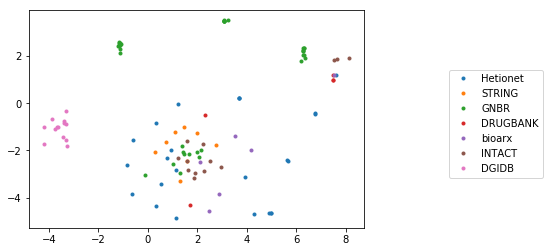

In [5]:
from matplotlib import cm
import matplotlib.pyplot as plt
from sklearn.utils import check_random_state
from sklearn.manifold import TSNE

dataset_id = {}
for rel_name, i in rel2id.items():
    rel_key = rel_name.split('::')[0]
    if dataset_id.get(rel_key, None) is None:
        dataset_id[rel_key] = []
    dataset_id[rel_key].append(i)

X_embedded = TSNE(n_components=2).fit_transform(rel_emb).T
p = cm.rainbow(int(255/2 * 1))
for key, val in dataset_id.items():
    val = np.asarray(val, dtype=np.long)

    plt.plot(X_embedded[0][val], X_embedded[1][val], '.', label=key)
    plt.legend(bbox_to_anchor=(0, 0, 1.55, 0.75))

plt.show()

## Pair-wise Relation Embedding Cosine Similarity
We calculate the pair-wise embedding similarity using cosine distance and output the top10 most similar pairs.

In [6]:
from sklearn.metrics.pairwise import cosine_similarity

similarity = cosine_similarity(rel_emb)
idx = np.flip(np.argsort(similarity), axis=1)

max_pairs = []
for i in range(idx.shape[0]):
    j = 1
    while (similarity[i][idx[i][j]] > 0.9):
        max_pairs.append((id2rel[idx[i][0]], id2rel[idx[i][j]], similarity[i][idx[i][j]]))
        j += 1

def sort_score(pair):
    return pair[2]

max_pairs.sort(reverse=True, key=sort_score)
sim_pairs = []
for i, pair in enumerate(max_pairs):
    if i % 2 == 0:
        sim_pairs.append(pair)

sim_pairs[:10]

[('GNBR::E::Compound:Gene', 'GNBR::K::Compound:Gene', 0.9825326),
 ('GNBR::E::Compound:Gene', 'GNBR::E+::Compound:Gene', 0.9790014),
 ('GNBR::E::Compound:Gene', 'GNBR::E-::Compound:Gene', 0.96299565),
 ('GNBR::N::Compound:Gene', 'GNBR::E-::Compound:Gene', 0.9628843),
 ('GNBR::K::Compound:Gene', 'GNBR::E+::Compound:Gene', 0.94823027),
 ('GNBR::E+::Compound:Gene', 'GNBR::E-::Compound:Gene', 0.9462117),
 ('GNBR::L::Gene:Disease', 'GNBR::G::Gene:Disease', 0.9400382),
 ('GNBR::J::Gene:Disease', 'GNBR::Te::Gene:Disease', 0.93304324),
 ('GNBR::K::Compound:Gene', 'GNBR::E-::Compound:Gene', 0.93287563),
 ('GNBR::J::Gene:Disease', 'GNBR::Md::Gene:Disease', 0.93212605)]

Then we draw a histogram of how the pair-wise similarity score distributed.

(11236,)


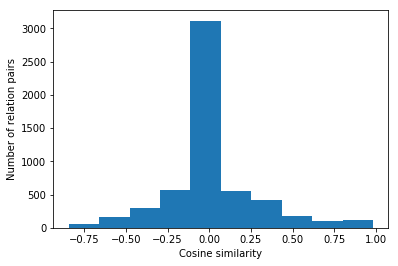

In [9]:
similarity=similarity.flatten()
print(similarity.shape)

# cleanup self-compare and dup-compare
s = similarity < 0.99
s = np.unique(similarity[s])
plt.xlabel('Cosine similarity')
plt.ylabel('Number of relation pairs')
plt.hist(s)
plt.show()

## Pair-wise Relation Embedding Frobenius Similarity
We calculate the pair-wise embedding similarity using L2 distance and output the top10 most similar pairs.

In [10]:
from sklearn.metrics.pairwise import euclidean_distances

similarity = euclidean_distances(rel_emb)
idx = np.argsort(similarity)

min_pairs = []
for i in range(idx.shape[0]):
    j = 1
    while (similarity[i][idx[i][j]] < 5):
        min_pairs.append((id2rel[idx[i][0]], id2rel[idx[i][j]], similarity[i][idx[i][j]]))
        j += 1

def sort_score(pair):
    return pair[2]

min_pairs.sort(key=sort_score)
sim_pairs = []
for i, pair in enumerate(min_pairs):
    if i % 2 == 0:
        sim_pairs.append(pair)

sim_pairs[:10]

[('GNBR::E::Compound:Gene', 'GNBR::K::Compound:Gene', 1.8725957),
 ('GNBR::E::Compound:Gene', 'GNBR::E+::Compound:Gene', 2.037919),
 ('GNBR::N::Compound:Gene', 'GNBR::E-::Compound:Gene', 2.605539),
 ('GNBR::E::Compound:Gene', 'GNBR::E-::Compound:Gene', 2.6699512),
 ('GNBR::K::Compound:Gene', 'GNBR::E+::Compound:Gene', 3.2253091),
 ('GNBR::E+::Compound:Gene', 'GNBR::E-::Compound:Gene', 3.2350895),
 ('GNBR::L::Gene:Disease', 'GNBR::G::Gene:Disease', 3.4676633),
 ('GNBR::J::Gene:Disease', 'GNBR::Te::Gene:Disease', 3.587521),
 ('GNBR::J::Gene:Disease', 'GNBR::Md::Gene:Disease', 3.5969605),
 ('GNBR::K::Compound:Gene', 'GNBR::E-::Compound:Gene', 3.6342802)]

Then we draw a histogram of how the pair-wise distance score distributed.

(11236,)


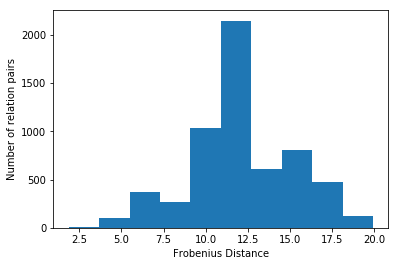

In [12]:
similarity=similarity.flatten()
print(similarity.shape)

# cleanup self-compare and dup-compare
s = similarity > 0
s = np.unique(similarity[s])
plt.xlabel('Frobenius Distance')
plt.ylabel('Number of relation pairs')
plt.hist(s)
plt.show()